# DD2424 - Gaze Prediction project

In [1]:
# load Data/normalize/preprocess
# process the data
# model parameters
# create model
# train model : input---> left eye, right eye, ,  grid || output---> distance from the camera in cm.
# evaluate
# fine tuning (if there is time)

## Load Dataset/Prepare/Normalize

In [2]:
import numpy as np
from skimage.color import rgb2gray

'''
    call readData() to import train and validation set 
    and prepare the image data to insert the CNN.
    set mode to 'gray' to return an [images x X x Y x 1] 
    instead of [images x X x Y x 3] array. 
'''

def readData():
    mode = ''
    data = np.load('./data/eye_tracker_train_and_val.npz')

#     train_face = data['train_face']
#     train_left_eye = data['train_eye_left']
#     train_right_eye = data['train_eye_right']
#     train_face_grid = data['train_face_mask']
#     train_labels = data['train_y']
    val_face = data['val_face']
#     val_left_eye = data['val_eye_left']
#     val_right_eye = data['val_eye_right']
#     val_face_grid = data['val_face_mask']
    val_labels = data['train_y']

#     train_data = [train_face, train_left_eye, train_right_eye, train_face_grid, train_labels]
#     val_data = [val_face, val_left_eye, val_right_eye, val_face_grid, val_labels]
    val_data = [val_face, val_labels]

#     train_data = prepare_data(train_data, mode)
    val_data = prepare_data(val_data, mode)

    return  val_data #train_data,


def prepare_data(data, mode):
#     face, left_eye, right_eye, face_grid, labels = data

    face, labels = data
    face = normalize(face, mode)
#     left_eye = normalize(left_eye, mode)
#     right_eye = normalize(right_eye, mode)
#     face_grid = face_grid.astype('float32').reshape(face_grid.shape[0], -1) # 2D array with num_images rows and X*Y*3 columns (since it goes directly to FC)
    labels = labels.astype('float32') # 2D array with num_images rows and 2 columns(x, y distance from camera)

    d = [face, labels]
    return d


def normalize(data, mode):
    shape = data.shape
    d = data.reshape(data.shape[0], -1) # 2D array with num_images rows and X*Y*3 columns
    d = d.astype('float32')/255 # constrain the values in [0, 1]
    d = d - np.mean(d, axis=0) # center the values around zeros
    d = d.reshape(shape) # 4D array (initial size of the array)
    if mode == 'gray':
        d = np.asarray([rgb2gray(d[i]) for i in range(d.shape[0])])
        d = d[..., None]
    return d



In [3]:
face_data = readData()
x_train = face_data[0][:10]
y_train = face_data[1][:10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


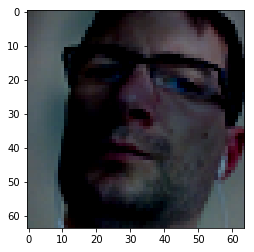

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(x_train[0])

## Define model Parameters

In [5]:
# Net params
img_size = 64
channels = 3
filter_size = 25

# left/right eyes and face:
conv1_size = 11
conv1_out = 96
pool1_size = 2
pool1_stride = 2

conv2_size = 5
conv2_out = 256
pool2_size = 2
pool2_stride = 2

conv3_size = 3
conv3_out = 384
pool3_size = 2
pool3_stride = 2

conv4_size = 1
conv4_out = 64
pool4_size = 2
pool4_stride = 2

# Fully-connected layers:
fc_e1_size = 128
fc_f1_size = 128
fc_f2_size = 64
fc_fg1_size = 256
fc2_fg2_size = 128
fc1_size = 128
fc2_size = 2

 ## Helper functions

In [6]:
import numpy as np
import tensorflow as tf

## Init weights

In [7]:
def init_weights(shape, name):
    return tf.get_variable(name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

## Init bias

In [8]:
def init_bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

## Conv2d

In [9]:
def conv2d(x, W, stride):
    # x ---> [batch, height, width, Channels]
    # W ---> [filter height, filter width, Channels IN, Channels OUT ]
    return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

## Pooling

In [10]:
def max_pooling(x, pool_size, stride):
    # x ---> [batch, height, width, Channels]
    return tf.nn.max_pool(x, ksize=[1, pool_size, pool_size, 1], strides=[1, stride, stride, 1], padding='VALID')

## Convolutional Layer

In [11]:
def convolution_layer(input_x, shape, stride, name):
    W = init_weights(shape, name)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W, stride) + b)

## Fully-Connected Layer

In [12]:
def fc_layer(input_layer, size, name):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size], name)
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [13]:
# -- NEXT:
# build out multiple layers along with the placeholders
# do loss function
# do optimizers
# initialize the variables
# run session

## Placeholders

In [14]:
# # create the placeholders (Graph input)
# left_e = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='left_eye')
# right_e = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='right_eye')
x = tf.placeholder(tf.float32, [None, img_size, img_size, channels], name='face')

# face_grid = tf.placeholder(tf.float32, [None, filter_size * filter_size], name='face_grid')
y = tf.placeholder(tf.float32, [None, 2], name='position')

## Layers

In [15]:
# convolutional layers
convo1_f = convolution_layer(x, [conv1_size, conv1_size, channels, conv1_out], 1, name='convo1_f')
pooling1_f = max_pooling(convo1_f, pool1_size, pool1_stride)

convo2_f = convolution_layer(pooling1_f, [conv2_size, conv2_size, conv1_out, conv2_out], 1, name='convo2_f')
pooling2_f = max_pooling(convo2_f, pool2_size, pool2_stride)

convo3_f = convolution_layer(pooling2_f, [conv3_size, conv3_size, conv2_out, conv3_out], 1, name='convo3_f')
pooling3_f = max_pooling(convo3_f, pool3_size, pool3_stride)

convo4_f = convolution_layer(pooling3_f, [conv4_size, conv4_size, conv3_out, conv4_out], 1, name='convo4_f')
pooling4_f = max_pooling(convo4_f, pool4_size, pool4_stride)

# fully connected layers
convo4_f_flat = tf.reshape(pooling4_f, [-1, 2 * 2 * 64])
fc1_f = tf.nn.relu(fc_layer(convo4_f_flat, 128, name = 'fc1_f'))

fc2_f = tf.nn.relu(fc_layer(fc1_f, 64, name = 'fc2_f'))

fc1 = tf.nn.relu(fc_layer(fc2_f, 128, name = 'fc1'))

y_pred = tf.nn.relu(fc_layer(fc1, 2, name = 'output'))



## Set optimizer

In [16]:
loss = tf.losses.mean_squared_error(y, y_pred)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)
error = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.squared_difference(y_pred, y), axis=1)))

## Initialize variables

In [17]:
init = tf.global_variables_initializer()


In [18]:
def batch(X, Y, size_batch):

    batch_x, batch_y = [], []
    for i in range(0, X.shape[0], size_batch):
        batch_x.append(X[i:i+size_batch])
        batch_y.append(Y[i:i+size_batch])
    return batch_x, batch_y

## Session

In [22]:
epochs = 30
batch_size = 1
n_batches = x_train[0].shape[0] / batch_size + (x_train[0].shape[0] % batch_size != 0)
train_loss_ls, train_error_ls = [], []
val_loss_ls, val_error_ls = [], []
train_loss, train_error = 0, 0


with tf.Session() as sess:
    sess.run(init)

    for ep in range(1, epochs+1):
        print('Epoch {}'.format(ep))
        x_batch, y_batch = batch(x_train, y_train, batch_size)
        for i in range(len(x_batch)):
            sess.run(optimizer, feed_dict={x: x_batch[i], y: y_batch[i]})
            
            train_batch_loss, train_batch_error = sess.run([loss, error], feed_dict={x: x_batch[i], y: y_batch[i]})
#             train_loss -= train_batch_loss / n_batches
#             train_error -= train_batch_error / n_batches

        train_loss_ls.append(train_batch_loss)
        train_error_ls.append(train_batch_error)
#         val_loss_ls.append(val_loss)
#         val_error_ls.append(val_error)
#         val_loss, val_error = sess.run([loss, error], feed_dict={x: x_val, y: y_val})


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

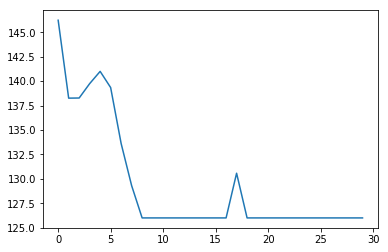